In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Ouverture du csv, un peu long car volumineux**

In [3]:
df=pd.read_csv('/content/gdrive/My Drive/Val_projet/airbnb.csv',";")

Le dataframe est immense et nous n'allons pas tout utiliser, nous supprimons toutes les colonnes qui ne sont pas utiles à notre recherche. Nous pourrons toujours venir les rechercher si nous en avons le besoin


In [4]:
#Premiere supression de variables pas utiles à notre analyse
df=df.drop(['Listing Url','Scrape ID','Last Scraped','Host Acceptance Rate','Scrape ID','Last Scraped',
            'Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Acceptance Rate',
           'Host Thumbnail Url','Host Picture Url','Host Verifications','Neighbourhood','Neighbourhood Group Cleansed',
           'Geolocation','Has Availability','Calendar last Scraped','License','Jurisdiction Names'], axis=1)

In [5]:
#deuxieme supression de variables pas utiles à notre analyse
df=df.drop(['Summary','Space','Experiences Offered','Notes','Access','State','Zipcode','Host Name','Host Location','Host Neighbourhood', 'Host ID',
           'Host Listings Count','Smart Location','Country Code','Square Feet','Security Deposit','Calendar Updated',
            'Guests Included','Extra People','Street','Country','Cancellation Policy','Calculated host listings count','Features','Market'], axis=1)

In [6]:
#On rename les colonnes qui ont des espaces
df.rename(columns={'ID':"id",'Name': 'name', 'Description': 'description', 'Host About': 'host_about', 'Host Response Time': 'host_response_time', 'Host Response Rate': 'host_response_rate', 'Host Total Listings Count': 'host_total_listing_count', 'Neighbourhood Cleansed': 'neighbourhood_cleansed' , 'City': 'city', 'Property Type': 'property_type', 'Room Type': 'room_type', 'Accommodates': 'accommodates'
, 'Bathrooms': 'bathrooms', 'Bedrooms': 'bedrooms', 'Beds': 'beds', 'Bed Type': 'bed_type', 'Amenities': 'amenities', 'Price': 'price', 'Weekly Price': 'weekly_price', 'Monthly Price': 'monthly_price', 'Cleaning Fee': 'cleaning_fee', 'Minimum Nights': 'minimum_nights', 'Maximum Nights': 'maximum_nights', 'Availability 30': 'availability_30', 'Availability 60': 'availability_60', 'Availability 90': 'availability_90', 'Availability 365': 'availability_365', 'Number of Reviews': 'number_of_reviews', 'First Review': 'first_review'
, 'Last Review': 'last_review', 'Review Scores Rating': 'review_scores_rating', 'Review Scores Accuracy': 'review_scores_accuracy', 'Review Scores Cleanliness': 'review_scores_cleanliness', 'Review Scores Checkin': 'review_scores_checkin', 'Review Scores Communication': 'review_scores_communication', 'Review Scores Location': 'review_scores_location', 'Review Scores Value': 'review_scores_value', 'Reviews per Month': 'reviews_per_month', 'Longitude': 'longitude','Latitude': 'latitude',"Neighborhood Overview":"neighborhood_overview","Transit":"transit","Interaction":"interaction","House Rules":"house_rules","Host Since":"host_since"}, inplace=True)

In [7]:
# on met la colonne id en index

df=df.set_index("id")

In [8]:
#Nous allons nous concentrer sur les villes de Paris et Londres, avant de commencer le nettoyage nous allons garder uniquement toutes les données concernant ces deux villes

#on divise le df par villes puis on les regroupe dans df
df_paris=df[df.city=='Paris']
df_london=df[df.city=='London']
df = df_paris.append(df_london)

# **Démarrons maintenant le nettoyage**

In [9]:
#On supprime les lignes dont les reviews ne sont pas renseignés étant donnée que c'est un point important de notre analyse
df=df.dropna(axis=0,subset=["first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])

In [10]:
#Maintenant que toutes les données ont une note attribuée, nous allons affiner en retirant les lignes qui ont des nans et qui peuvent fausser notre analyse.
df=df.dropna(axis=0,subset=["description","name","host_since","host_total_listing_count","price"]) 

In [11]:
#On supprime ces deux variables qui présentent trop de données manquantes pour être exploitées et qui sont difficiles à remplacer sans impacter les résultats de l'analyse
df=df.drop(['host_response_time','host_response_rate'], axis=1)

In [12]:

df["neighborhood_overview"]=df["neighborhood_overview"].fillna("nr")
df["transit"]=df["transit"].fillna("nr")
df["interaction"]=df["interaction"].fillna("nr")
df["house_rules"]=df["house_rules"].fillna("nr")
df["host_about"]=df["host_about"].fillna("nr")
df["amenities"]=df["amenities"].fillna("nr")
df["bathrooms"]=df["bathrooms"].fillna(0)
df["bedrooms"]=df["bedrooms"].fillna(0)
df["beds"]=df["beds"].fillna(0)
df["weekly_price"]=df["weekly_price"].fillna(0)
df["monthly_price"]=df["monthly_price"].fillna(0)
df["cleaning_fee"]=df["cleaning_fee"].fillna(0)


In [13]:

#On stock les variables numérique dans num_df
num_df=df.select_dtypes(include="float64")



 Il semble y avoir des valeurs abérrantes dans maximum_nights pour avoir des valeurs si élevées

 Nous allons donc regarder cette variable ainsi que minimum_nights

In [14]:
#On change les valeur aberrante (qui depasse 365jours) de maximum_nights en valeur de la variable 'availability_365', qui semble plus logique
num_df['maximum_nights'] = np.where(num_df['maximum_nights'] > 365, num_df['availability_365'], num_df['maximum_nights'])


In [15]:
#On modifie les valeurs abérrantes de minimum_nights en remplaçant toutes les valeurs au dessus de 31 jours par 1
num_df.minimum_nights[num_df.minimum_nights > 31] = 1


# **Analyse des variables catégorielles**

In [16]:
#On determine les variables catégorielles et on les stock dans cat_df
cat_df = df.select_dtypes(include=['O'])

In [17]:
#Nous allons garder uniquement les types de propriété 'Apartment' et 'House' qui représente 99,6% du dataset
cat_df['property_type']=cat_df['property_type'].loc[cat_df['property_type'].isin(['Apartment','House'])]

#On supprime les ligne qui ne sont pas des appartement ou maison (devenu Nans avec le code précédent) 
cat_df=cat_df.dropna(axis=0,subset=['property_type'])

In [18]:
#Nous allons garder uniquement les types de chambre 'Entire home/apt' et 'Private room' qui représente 99,9% du dataset
cat_df['room_type']=cat_df['room_type'].loc[cat_df['room_type'].isin(['Entire home/apt','Private room'])]

#On supprime les ligne qui ne sont pas des 'Entire home/apt' ou 'Private room' (devenu Nans avec le code précédent) 
cat_df=cat_df.dropna(axis=0,subset=['room_type'])

beaucoup de variables catégorielles sont remplies librement par les propriétaires et donc quasiment toutes différentes.
Il conviendra donc de faire du text mining pour les analyser ultérieurement. 

In [19]:
#On ré-assemble le dataframe variable numerique + variable catégorielles
df=pd.concat([num_df,cat_df],axis=1)

In [20]:
# Mettons maintenant ces variables au format datetime

df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [21]:
#Maintenant le que le df est reconstitué, on supprime les lignes qui contiennent des Nans du fait des changements dans cat_df
df=df.dropna(axis=0)


In [22]:
#on divise le df par villes puis on les regroupe dans df pour ecraser les données précédentes de df_london et df_paris
df_paris=df[df.city=='Paris']
df_london=df[df.city=='London']
#On supprimme la première ligne de df_london car elle pose problème pour la visualisation par la suite et elle contient beaucoup de valeurs "Non-renseignées"
df_london.drop( df_london.index[0], inplace=True)
df = df_paris.append(df_london)

In [ ]:
# Variables texte à analyser: name, description, neighborhood_overview,transit,interaction

In [23]:
# Importations

## for data
import collections
import json
## for plotting
import wordcloud
## for text processing
import re
import nltk
## for language detection
!pip install langdetect
import langdetect 
## for sentiment
from textblob import TextBlob
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim

     |████████████████████████████████| 981 kB 30.9 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=e807d812d95bcf1a7e6187eaff0b9c6cc6c4eebc1ca07690698139c4419ae5ee
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [24]:
name_string =  "\n\n".join(df.name)

# On commence par analyser les noms donnés aux logements 

In [ ]:
#Commençons par nettoyer les données textuelles de la variable name

name_string = re.sub('\s+',' ',name_string).strip().lower()
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris ! studio saint paul 160 m2 place des vosges .marais. heart marais-22m2 lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large 1 bedr app - heart of paris charming studio in the marais studio poutres apparentes centre pompidou 2 bedrooms - 50m2 - marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest! - le marais paris historical center appt de caractère ile saint louis g04531 impressive 3'

In [ ]:
r=re.compile(r"[0-9]")
name_string=r.sub(" ",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris ! studio saint paul     m  place des vosges .marais. heart marais-  m  lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large   bedr app - heart of paris charming studio in the marais studio poutres apparentes centre pompidou   bedrooms -   m  - marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest! - le marais paris historical center appt de caractère ile saint louis g      impressive  '

In [ ]:
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
name_string=r.sub(" ",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris   studio saint paul     m  place des vosges  marais  heart marais   m  lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large   bedr app   heart of paris charming studio in the marais studio poutres apparentes centre pompidou   bedrooms     m    marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest    le marais paris historical center appt de caractère ile saint louis g      impressive  '

In [ ]:
r=re.compile(r"[\s]{2,}")
name_string=r.sub(" ",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacio'

In [ ]:
r=re.compile(r"\bdb\b")
name_string=r.sub("double",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacio'

In [ ]:
r=re.compile(r"\binc\b")
name_string=r.sub("included",name_string)
name_string[:600]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacio'

In [ ]:
r=re.compile(r"\bwi\sfi\b")
name_string=r.sub("wifi",name_string)
name_string[:900]

'petit cocon au coeur de paris enjoy the lovely heart of paris studio saint paul m place des vosges marais heart marais m lovely studio charming marais studio au coeur du marais new design marais one bedroom authentic appartement heart of the marais large bedr app heart of paris charming studio in the marais studio poutres apparentes centre pompidou bedrooms m marais petite chambre dans le marais ❤ lovely flat in the marais ❤ studio hyper center le marais maison marais be my guest le marais paris historical center appt de caractère ile saint louis g impressive bedrooms apart light bright spacious bd in heart of marais studio meuble le marais st paul lovely apartement in the heart of le marais le marais place vosges calm studio romantic flat in paris le marais charming small apartment rooms brand new unique studio romantic or business charming studio marais beautiful appartment in the mara'

In [ ]:
r=re.compile(r"\bnr\b")
name_string=r.sub("near",name_string)
#name_string[:900]

In [ ]:
import re
def remove_emojis(name_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',name_string)

In [ ]:
# tokenisation
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(name_string)
name_tokenized=word_tokenize(name_string,language="english")
#name_tokenized[:90]

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st"])
# j'ajoute manuellement les stop words en français les plus communs car nous avons dû choisir une langue sur les deux utilisées dans ce dataset
# j'ai essayé de traduire les mots français en anglais mais ça a bloqué.
# Comme nous comprenons les deux langues cela n'est pas vraiment gênant pour notre analyse, à l'interne

In [ ]:
#stop_words

In [ ]:
def stop_words_filtering(name_tokenized) : 
    tokens = []
    for mot in name_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_name = [w for w in name_tokenized if not w.lower() in stop_words]
 
filtered_name = []
 
for w in name_tokenized:
    if w not in stop_words:
        filtered_name.append(w)
 
#print(name_tokenized)
#filtered_name[:90]

['petit',
 'cocon',
 'au',
 'coeur',
 'enjoy',
 'lovely',
 'heart',
 'studio',
 'saint',
 'paul',
 'place',
 'vosges',
 'marais',
 'heart',
 'marais',
 'lovely',
 'studio',
 'charming',
 'marais',
 'studio',
 'au',
 'coeur',
 'marais',
 'new',
 'design',
 'marais',
 'bedroom',
 'authentic',
 'appartement',
 'heart',
 'marais',
 'large',
 'bedr',
 'app',
 'heart',
 'charming',
 'studio',
 'marais',
 'studio',
 'poutres',
 'apparentes',
 'centre',
 'pompidou',
 'bedrooms',
 'marais',
 'petite',
 'chambre',
 'marais',
 '❤',
 'lovely',
 'flat',
 'marais',
 '❤',
 'studio',
 'hyper',
 'center',
 'marais',
 'maison',
 'marais',
 'guest',
 'marais',
 'historical',
 'center',
 'appt',
 'caractère',
 'ile',
 'saint',
 'louis',
 'impressive',
 'bedrooms',
 'apart',
 'light',
 'bright',
 'spacious',
 'heart',
 'marais',
 'studio',
 'meuble',
 'marais',
 'paul',
 'lovely',
 'apartement',
 'heart',
 'marais',
 'marais',
 'place',
 'vosges',
 'calm',
 'studio',
 'romantic']

In [ ]:
# Vectorisation:

# Connaître l'occurence des mots utilisés pour nommer les logements:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_name)
tokenized=vectorizer.vocabulary_
#tokenized


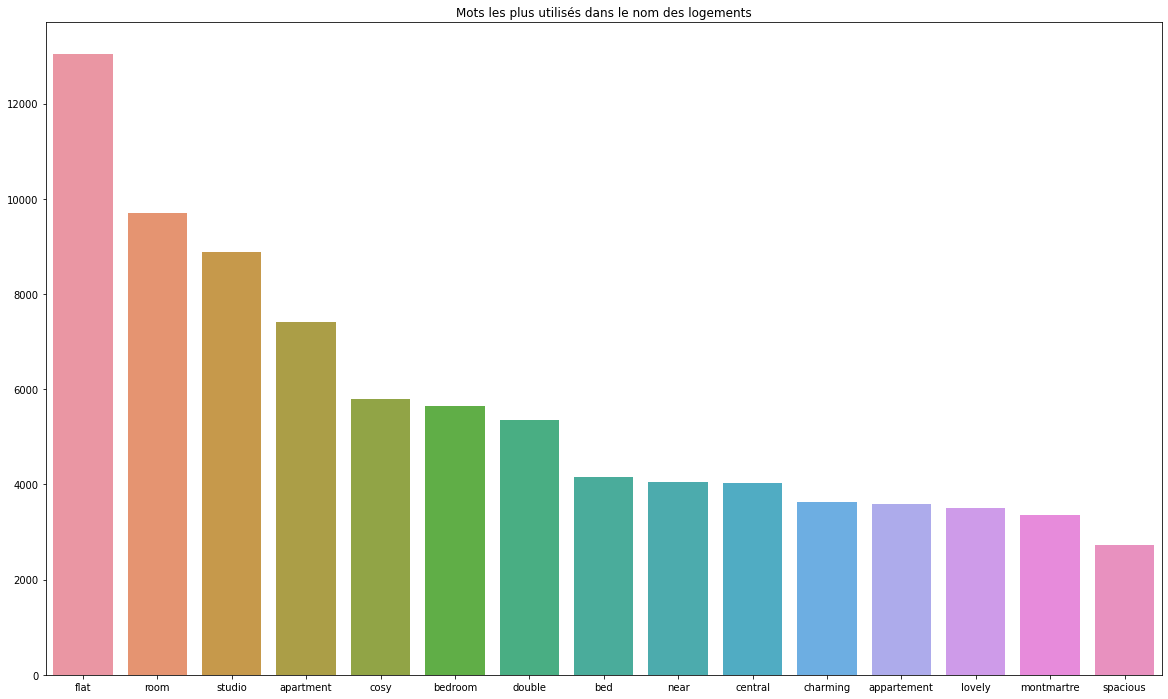

In [ ]:
from collections import Counter
import seaborn as sns
dico=Counter(filtered_name)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans le nom des logements");

# on pourrait faire le même exercice en différenciant les logements à Londres et à Paris
# mais cela nous indique déjà que les éléments les plus importants mis en valeur par les propriétaires 
# sont le type de logement, leur taille, leur localisation.
# les propriétaires sont également nombreux à utiliser des adjectifs qualificatifs positifs pour attirer les clients

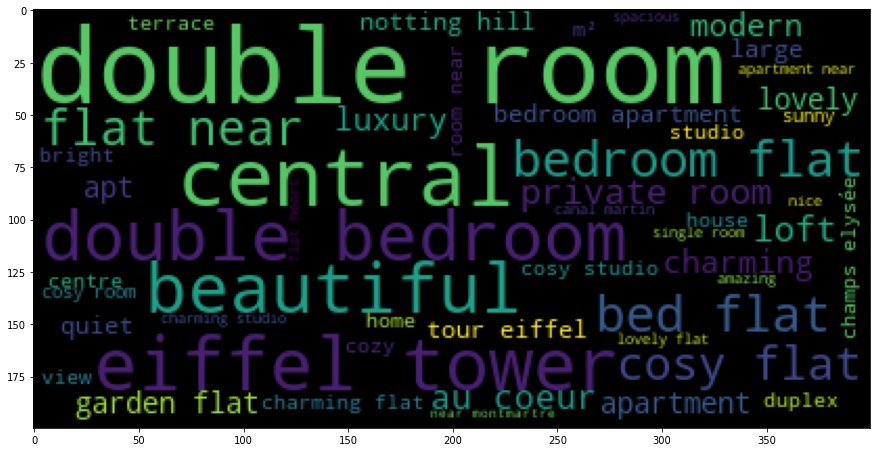

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc=WordCloud(background_color="black",max_words=50,stopwords=stop_words,max_font_size=50,random_state=42)
plt.figure(figsize=(15,8))
wc.generate(name_string)
plt.imshow(wc);

In [ ]:
#Analysons à présent la variable neighborhood_overview
neighborhood_string =  "\n\n".join(df.neighborhood_overview)

In [ ]:
#nettoyage des données textuelles
neighborhood_string = re.sub('\s+',' ',neighborhood_string).strip().lower()
neighborhood_string[:600]

'mon quartier "le marais" est unique à paris. a taille humaine, tout est accessible à pieds , un must dans la capitale ! le marais est un quartier incroyable pour se balader, découvrir les musées, les restaurants et surtout les jardins cachés entre les différents bâtiments ! il y a toujours de l\'animation, même le dimanche :-) located on a great and quiet neighbourhood, with easy access to all the city\'s most famous landmarks. the apartment is in the center of paris , in the marais , in the oldest area of paris , in a royal place . -a large variety of restaurants (rue des rosiers within 1 minut'

In [ ]:
r=re.compile(r"[0-9]")
neighborhood_string=r.sub(" ",neighborhood_string)

r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
neighborhood_string=r.sub(" ",neighborhood_string)

r=re.compile(r"[\s]{2,}")
neighborhood_string=r.sub(" ",neighborhood_string)

r=re.compile(r"\bdb\b")
neighborhood_string=r.sub("double",neighborhood_string)

r=re.compile(r"\bwi\sfi\b")
neighborhood_string=r.sub("wifi",neighborhood_string)

r=re.compile(r"\bnr\b")
neighborhood_string=r.sub("near",neighborhood_string)

neighborhood_string[:600]

'mon quartier le marais est unique à paris a taille humaine tout est accessible à pieds un must dans la capitale le marais est un quartier incroyable pour se balader découvrir les musées les restaurants et surtout les jardins cachés entre les différents bâtiments il y a toujours de l animation même le dimanche located on a great and quiet neighbourhood with easy access to all the city s most famous landmarks the apartment is in the center of paris in the marais in the oldest area of paris in a royal place a large variety of restaurants rue des rosiers within minutes walk cafes and shops are aro'

In [ ]:
import re
def remove_emojis(neighborhood_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',neighborhood_string)

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(neighborhood_string)
neighborhood_tokenized=word_tokenize(neighborhood_string,language="english")
#neighborhood_tokenized[:90]

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st","l","s","et","à","also"])

def stop_words_filtering(neighborhood_tokenized) : 
    tokens = []
    for mot in neighborhood_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

filtered_neighborhood = [w for w in neighborhood_tokenized if not w.lower() in stop_words]
filtered_neighborhood = []
 
for w in neighborhood_tokenized:
    if w not in stop_words:
        filtered_neighborhood.append(w)

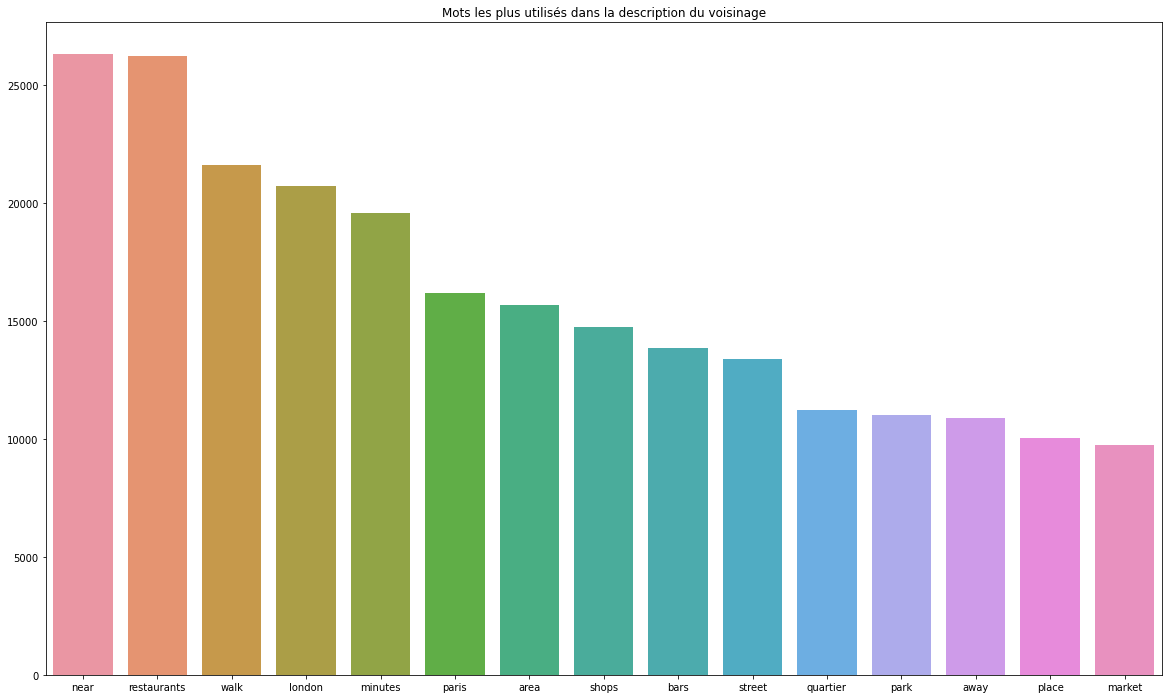

In [ ]:
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_neighborhood)
tokenized=vectorizer.vocabulary_

dico=Counter(filtered_neighborhood)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans la description du voisinage");

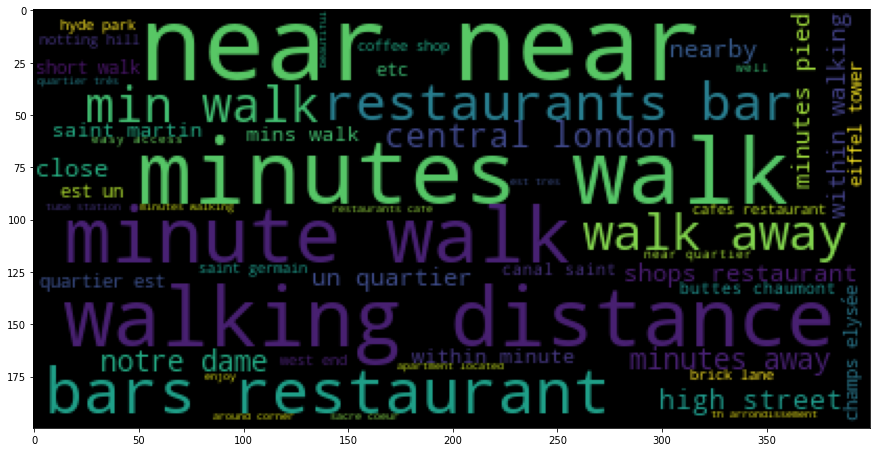

In [ ]:
wc=WordCloud(background_color="black",max_words=50,stopwords=stop_words,max_font_size=50,random_state=42)
plt.figure(figsize=(15,8))
wc.generate(name_string)
plt.imshow(wc);